<a href="https://colab.research.google.com/github/dhyeybhatpuria/Crux_Alliance/blob/master/Ex2_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Exercise 2**

Since Visualisation of layers is done using GEEMAP package. Below line will install geemap to colab

In [89]:
!pip install geemap

Run the below line and Please provide permission to access colab and also GEE credentials with all access. 

In GEE notebook authenticator, select default cloud project, Set data access to read-only scopes. 
Allow:
*   View your Google Earth Engine data
*   View your data in Google Cloud Storage.
Copy the code generated in box within below line "Verification Code:"

Code in notebook requires these permissions to run using free quota of GEE and it will not copy, modify any existing datasets in your GEE assets or Google Cloud Platform (GCP). 

In [90]:
# Installs geemap package
import google.colab
from google.colab import auth
auth.authenticate_user()
import geemap.eefolium as geemap
import geemap as gmap
# Authenticates and initializes Earth Engine
import ee
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=u8aLJ3bzo1ocAK4WqvF73dhBdmW6pdPIOn1MB2nPuI0&tc=Cv4PFvKpNkdywUltnrIGdIN4Yr2NvWogM5Ikfv1eTlo&cc=tUtwWjVHIJmanl_eFt5hKfbdyP18NsXYsMZ_tGoPGo4

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWhg5CmnN3ulTery_uqG75qb7ShzpMD6oSGXMjwqNctepjKzFxa9AGM

Successfully saved authorization token.


Calculation of Indices \
Formula of NDVI is $(NIR-RED)/(NIR+RED)$ \
Formula of NDWI is $(GREEN-NIR)/(GREEN+NIR)$

In [91]:
# Create functions for calculating NDVI and NDWI and append them to the image as a band
def calc_indices(image):
  ndvi = (image.normalizedDifference(['B5', 'B4'])).rename("NDVI") # B5 is NIR ,B4 is Red
  ndwi = (image.normalizedDifference(['B3', 'B5'])).rename("NDWI") # B5 is NIR ,B3 is Green
  return image.addBands(ndvi).addBands(ndwi)

In [92]:
# Load Landsat 
landsat = ee.ImageCollection("LANDSAT/LC08/C02/T1_TOA")
areaofint = ee.FeatureCollection("users/dhyeybhatpuria/India_Boundary")
Landsat_indices = landsat \
  .filterDate('2021-01-01', '2021-12-31') \
  .map(calc_indices) \
  .median() \
  .clip(areaofint)

In [93]:
# Visualisation parameter
import geemap.colormaps as cm
vis_parameters = {'bands': ['B4', 'B3', 'B2'], 'min':0, 'max': 0.3};
# colorpalette1 =  ['FFFFFF','CC9966','CC9900', '996600', '33CC00', '009900','006600','000000']
colorpalette =  ['green', 'yellow','red'] # Standard palette
# geemap based palette
palette_ndvi = cm.palettes.ndvi
ndvi_parameter = {'min':-0.5, 'max': 1, 'palette':palette_ndvi}
palette_ndwi = cm.palettes.ndwi
ndwi_parameter = {'min':-0.5, 'max': 1, 'palette':palette_ndwi}

In [94]:
Map = geemap.Map(center=[23,78], zoom= 5)
Map.addLayer(Landsat_indices.select("NDWI"), ndwi_parameter, 'Median NDWI')
Map.addLayer(Landsat_indices.select("NDVI"), ndvi_parameter, 'Median NDVI')
# Map.add_colorbar(ndwi_parameter, label= "NDWI", layer_name = "Median NDWI")
# Map.add_colorbar(ndvi_parameter,label= "Index", layer_name="Median NDVI")
Map.addLayerControl()
Map
# Toggle layers from layers tab in right side of the map area

**Exercise 3**

In [116]:
modis_lulc = ee.ImageCollection('MODIS/006/MCD12Q1')
# filter for date, select only IGBP LULC
lc = modis_lulc \
  .filterDate('2020-01-01', '2020-12-31') \
  .select('LC_Type1') \
  .first()


agricultural_mask = lc.eq(12) \
  .selfMask()

forest_lc = (lc.lte(10)).multiply(1)
agro_lc = (lc.eq(12).Or(lc.eq(14))).multiply(2)
urban_lc = (lc.eq(13)).multiply(3)
water_lc = (lc.eq(17)).multiply(4)
other_lc = (((lc.eq(15)).Or(lc.eq(16))).Or(lc.eq(11))).multiply(5)
classified = (forest_lc.add(agro_lc).add(urban_lc).add(water_lc).add(other_lc)).clip(areaofint)

agricultural_mask = classified.eq(2).selfMask()

In [117]:
ndvi_layer = Landsat_indices.select("NDVI")
agro_ndvi = (ee.Image(ndvi_layer) \
             .mask(agricultural_mask)) \
             .clip(areaofint)

On running below line please check in right tab to toggle LULC and Masked NDVI

In [118]:
igbpLandCoverVis = {'min': 1.0, 'max': 5.0, 'palette': ['green','yellow','brown','blue','gray']}

Map = geemap.Map(center=[23,78], zoom= 5)
Map.addLayer(classified, igbpLandCoverVis, 'Classified LULC')
# Green = forest, Yellow = Agriculture, Brown = Urban, Blue = water and Gray = Others
Map.addLayer(agro_ndvi.clip(areaofint), ndvi_parameter, 'NDVI-Agriculture land only')

# Map.add_colorbar(ndwi_parameter, label= "NDWI", layer_name = "Median NDWI")
# Map.add_colorbar(ndvi_parameter,label= "Index", layer_name="Median NDVI")
Map.addLayerControl()
Map

Exercise 4
Lastly provide statistics from the four classes derived from the MODIS land cover map conducted in exercise 3.

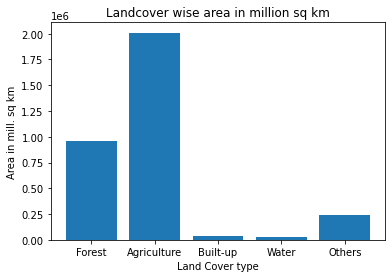

In [122]:
areaImage = ee.Image.pixelArea().addBands(classified)
areas = areaImage.reduceRegion(reducer=ee.Reducer \
                               .sum() \
                               .group(groupField=1,groupName='class'),
                               geometry=areaofint.geometry(),scale=1000,
                               maxPixels=1e13)
classAreas = ee.List(areas.get('groups'))

def calclists(item):
   areaDict = ee.Dictionary(item)
   classNumber = ee.Number(areaDict.get('class')).format()
   area = ee.Number(areaDict.get('sum')).divide(1e6)
   return ee.List([classNumber, area])

classAreaLists = classAreas.map(calclists)
result = ee.Dictionary(classAreaLists.flatten())
out = result.getInfo()
out['Forest'] = out.pop('1')
out['Agriculture'] = out.pop('2')
out['Built-up'] = out.pop('3')
out['Water'] = out.pop('4')
out['Others'] = out.pop('5')

import matplotlib.pyplot as plt
plt.bar(range(len(out)), list(out.values()), align='center')
plt.xticks(range(len(out)), list(out.keys()))
plt.xlabel("Land Cover type")
plt.ylabel("Area in mill. sq km")
plt.title("Landcover wise area in million sq km")
plt.show()


In [ ]:
# Histogram of pixel count for each land cover type
import geemap.chart as chart
my_sample = classified.sample(areaofint, 5000)
property = 'LC_Type1'
options = {
    "title": 'Histogram',
    "xlabel": 'LULC',
    "ylabel": 'Pixel count',
    "colors": ['#1d6b99'],
}
chart.feature_histogram(my_sample, property, **options)